In [281]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import statistics
import numpy as np
import math
from scipy import stats
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.cluster import KMeans
import geopandas as gpd
import warnings
from gekko import GEKKO
warnings.filterwarnings('ignore')

### General EDA

In [14]:
# processing waste data
loads_df = pd.read_csv("waste_collection.csv").iloc[:, 1:]
loads_df

,Load Type,Load Time,Load Weight,Dropoff Site,Route Type,Route Number,Load ID,Load Date
0,RECYCLING - PAPER,2000-01-26 12:39:00,2940.0,MRF,RECYCLING,RH12,163262,2000-01-26 00:00:00
1,BULK,2001-03-16 09:38:00,4240.0,TDS LANDFILL,BULK,BU05,522335,2001-03-16 00:00:00
2,BULK,2001-03-16 13:33:00,4740.0,TDS LANDFILL,BULK,BU05,522334,2001-03-16 00:00:00
3,BULK,2001-10-16 11:51:00,14080.0,TDS LANDFILL,BULK,BU16,545997,2001-10-16 00:00:00
4,BULK,2001-10-16 15:28:00,8260.0,TDS LANDFILL,BULK,BU16,545996,2001-10-16 00:00:00
...,...,...,...,...,...,...,...,...
655357,BULK,2021-07-11 07:07:01,10100.0,TDS LANDFILL,BULK,BU27,842414,2021-07-11 00:00:00
655358,TIRES,2021-07-11 07:07:05,1500.0,TDS LANDFILL,BULK,BU16,848381,2021-07-11 00:00:00
655359,TIRES,2021-07-11 07:07:05,2120.0,MRF,BULK,BU16,848380,2021-07-11 00:00:00
655360,GARBAGE COLLECTIONS,2021-07-11 07:07:42,17200.0,TDS LANDFILL,GARBAGE COLLECTION,PW30,928229,2021-07-11 00:00:00


In [15]:
loads_df['Load Weight'] = loads_df['Load Weight'].astype(float)
loads_df[['Date','Time']] = loads_df['Load Time'].str.split(' ', expand=True)
loads_df[['Year','Month', 'Day']] = loads_df['Date'].str.split('-', expand=True)
loads_df['Year'] = loads_df['Year'].astype(int)
loads_df['Load Weight'] = loads_df['Load Weight'].astype(float)
loads_df

,Load Type,Load Time,Load Weight,Dropoff Site,Route Type,Route Number,Load ID,Load Date,Date,Time,Year,Month,Day
0,RECYCLING - PAPER,2000-01-26 12:39:00,2940.0,MRF,RECYCLING,RH12,163262,2000-01-26 00:00:00,2000-01-26,12:39:00,2000,01,26
1,BULK,2001-03-16 09:38:00,4240.0,TDS LANDFILL,BULK,BU05,522335,2001-03-16 00:00:00,2001-03-16,09:38:00,2001,03,16
2,BULK,2001-03-16 13:33:00,4740.0,TDS LANDFILL,BULK,BU05,522334,2001-03-16 00:00:00,2001-03-16,13:33:00,2001,03,16
3,BULK,2001-10-16 11:51:00,14080.0,TDS LANDFILL,BULK,BU16,545997,2001-10-16 00:00:00,2001-10-16,11:51:00,2001,10,16
4,BULK,2001-10-16 15:28:00,8260.0,TDS LANDFILL,BULK,BU16,545996,2001-10-16 00:00:00,2001-10-16,15:28:00,2001,10,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
655357,BULK,2021-07-11 07:07:01,10100.0,TDS LANDFILL,BULK,BU27,842414,2021-07-11 00:00:00,2021-07-11,07:07:01,2021,07,11
655358,TIRES,2021-07-11 07:07:05,1500.0,TDS LANDFILL,BULK,BU16,848381,2021-07-11 00:00:00,2021-07-11,07:07:05,2021,07,11
655359,TIRES,2021-07-11 07:07:05,2120.0,MRF,BULK,BU16,848380,2021-07-11 00:00:00,2021-07-11,07:07:05,2021,07,11
655360,GARBAGE COLLECTIONS,2021-07-11 07:07:42,17200.0,TDS LANDFILL,GARBAGE COLLECTION,PW30,928229,2021-07-11 00:00:00,2021-07-11,07:07:42,2021,07,11


Text(0.5, 1.0, 'Total Weight (lbs) Collected by Year')

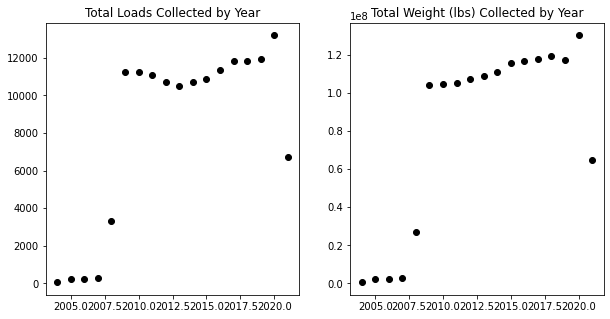

In [323]:
# finding relevant years for analysis by number of loads
aux = loads_df.loc[loads_df['Load Type']=='RECYCLING - SINGLE STREAM']
aux = aux.groupby(['Year']).agg({'Load Weight':'sum', 'Load ID': 'count'}).reset_index()
aux.rename(columns={"Load Weight": "Total_Weight", "Load ID": "Total_Loads"}, inplace=True)
aux[['Total_Loads']]=aux[['Total_Loads']].astype(int)
fig, axs = plt.subplots(1,2, figsize=(10,5), sharex = True)
axs[0].scatter(aux[['Year']],aux[['Total_Loads']], color='black')
axs[0].set_title('Total Loads Collected by Year')
axs[1].scatter(aux[['Year']],aux[['Total_Weight']], color='black')
axs[1].set_title('Total Weight (lbs) Collected by Year')


In [325]:
(117167383-104823890)/104823890*100

11.77545786556862

Data between 2010 and 2019 (including) seem to follow a more reliable trend both in number of loads and in total weight:
* Before 2010 there was potentially a different strategy for collection and before 2005 there's seems to be incomplete data
* In 2020 there  was a drastic reduction in no. of loads and weight collected, which is a very visible result of the consequences of consistent lockdowns during the Covid-19 pandemic

This way, we'll focus our analysis for the years between 2010 and 2019

In [33]:
filtered_loads_df = loads_df[(loads_df['Year'] >= 2010) & (loads_df['Year'] < 2020)]
filtered_loads_df.head()

,Load Type,Load Time,Load Weight,Dropoff Site,Route Type,Route Number,Load ID,Load Date,Date,Time,Year,Month,Day
210581,YARD TRIMMING,2010-01-02 00:00:00,11500.0,HORNSBY BEND,YARD TRIMMINGS,YF05,352641,2010-01-02 00:00:00,2010-01-02,00:00:00,2010,01,02
210582,LITTER,2010-01-02 06:35:00,2860.0,TDS LANDFILL,KAB,KAB07,353333,2010-01-02 00:00:00,2010-01-02,06:35:00,2010,01,02
210583,LITTER,2010-01-02 08:30:00,8140.0,TDS LANDFILL,SWEEPER DUMPSITES,DSS04,353337,2010-01-02 00:00:00,2010-01-02,08:30:00,2010,01,02
210584,RECYCLING - SINGLE STREAM,2010-01-02 08:54:00,6600.0,MRF,RECYCLING - SINGLE STREAM,DF2,352865,2010-01-02 00:00:00,2010-01-02,08:54:00,2010,01,02
210585,RECYCLING - SINGLE STREAM,2010-01-02 09:11:00,6180.0,MRF,RECYCLING - SINGLE STREAM,RFBS40A,352868,2010-01-02 00:00:00,2010-01-02,09:11:00,2010,01,02


#### Waste production general stats

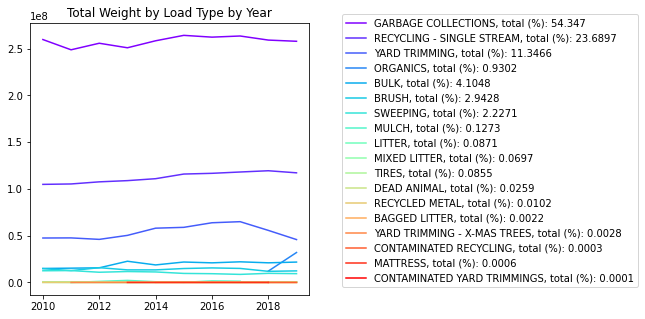

In [56]:
# Total waste and specific waste weight by year 
aux = filtered_loads_df.copy()
aux = aux.groupby(['Load Type', 'Year']).agg({'Load Weight':'sum', 'Load ID': 'count'}).reset_index()
aux.rename(columns={"Load Weight": "Total_Weight", "Load ID": "Total_Loads"}, inplace=True)
ordered = aux.sort_values(by='Total_Weight', ascending=False)
# Plot per load types
load_types = list(ordered['Load Type'].unique())
fig, axs = plt.subplots(1, figsize=(5,5), sharex = True)
total = aux['Total_Weight'].sum()
colors = cm.rainbow(np.linspace(0, 1, len(load_types)))
for load_type, c in zip(load_types, colors):
    plot_df = aux[aux['Load Type'] == load_type]
    total_by_type = plot_df['Total_Weight'].sum()
    axs.plot(plot_df[['Year']],plot_df[['Total_Weight']], color=c, label = f'{load_type}, total (%): {round(total_by_type/total * 100, 4)}')
axs.set_title('Total Weight by Load Type by Year')
axs.legend(bbox_to_anchor=(1.1, 1.05))


Although total waste collected has incfreased through the years, the proportions of each load type hasn't changed much, with common garbage collection accounting for more than 50% of total waste, with recycling appearing as a far second accounting for about 23% of total weight collected.

We'll focus mainly on these 2 load types

In [313]:
filtered_loads_df['Load Weight'].sum()

4746597133.0

#### Relationship with Population

<AxesSubplot:xlabel='Year'>

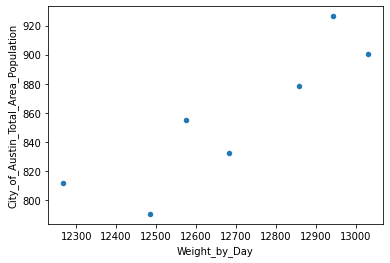

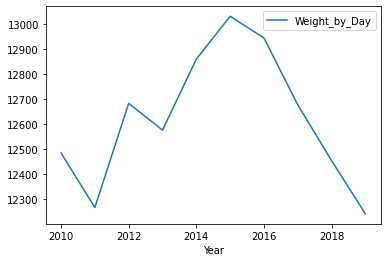

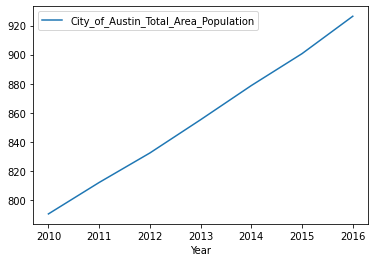

In [311]:
waste_by_year = filtered_loads_df.groupby(['Year']).agg({'Load Weight':'sum', 'Day': 'count',}).reset_index()
waste_by_year.rename(columns={"Load Weight": "Total_Weight", "Day": "Total_Days"}, inplace=True)
waste_by_year["Weight_by_Day"] = waste_by_year["Total_Weight"] / waste_by_year["Total_Days"]

population_df = pd.read_excel("austion_population_growth.xlsx")
population_df = population_df[(population_df['Year'] >= 2010) & (population_df['Year'] < 2020)]

# join both dataframes
_waste_population_df = waste_by_year.merge(population_df, how = 'left', left_on = 'Year', right_on = 'Year')
_waste_population_df = _waste_population_df[['Year','Total_Weight','Weight_by_Day','City_of_Austin_Total_Area_Population']]
_waste_population_df = _waste_population_df.dropna()

_waste_population_df.plot(x ='Weight_by_Day', y='City_of_Austin_Total_Area_Population', kind = 'scatter')
waste_by_year.plot(x ='Year', y='Weight_by_Day', kind = 'line')
_waste_population_df.plot(x ='Year', y='City_of_Austin_Total_Area_Population', kind = 'line')



Although population increased, it appears to have no relation with waste collected per day. Besides, this value shows inconstant variations along the year (no detectable trend through the years, except for the rapid increase since 2019)

### Detecting Flaws and Improving Garbage Collection

#### Potential Improvements Identification

The most practical way to detect potential improvements in garbage collection, is to assess the relationship between the total loads and total weight collected per collection route, assuming that the number of loads are representative of the total trips done by garbage trucks.

The routes with the lowest weight collected in comparison with the loads done, will then represent areas were the collections can be rethinked.

We'll analyse the collections from the year 2019 (as it is the most recent year that probably represents production trends more accurately)

In [69]:
garbage_loads_df = filtered_loads_df[(filtered_loads_df['Load Type'] == "GARBAGE COLLECTIONS")]
loads_by_route = garbage_loads_df.copy()
loads_by_route = loads_by_route[(loads_by_route['Year'] == 2019) ]
loads_by_route = loads_by_route.groupby(['Route Number']).agg({'Load Weight':'sum', 'Load ID': 'count'}).reset_index()
loads_by_route.rename(columns={"Load Weight": "Total_Weight", "Load ID": "Total_Loads"}, inplace=True)
loads_by_route['Weight_By_Load'] = loads_by_route['Total_Weight'] / loads_by_route['Total_Loads']
print(f'Routes:{len(loads_by_route)}')
print(f"Max Loads:{loads_by_route['Total_Loads'].max()}")
print(f"Min Loads:{loads_by_route['Total_Loads'].min()}")
loads_by_route

Routes:292
Max Loads:108
Min Loads:1


,Route Number,Total_Weight,Total_Loads,Weight_By_Load
0,DW1,2280.0,1,2280.000000
1,OH-4,11940.0,1,11940.000000
2,PAF01,1062100.0,52,20425.000000
3,PAF02,1208240.0,51,23690.980392
4,PAF03,1079080.0,53,20360.000000
...,...,...,...,...
287,PW41,2142000.0,106,20207.547170
288,WNONAC,30540.0,1,30540.000000
289,YH06,10340.0,1,10340.000000
290,YM11,5880.0,1,5880.000000


Text(0.5, 1.0, 'Weight/ Load by Route')

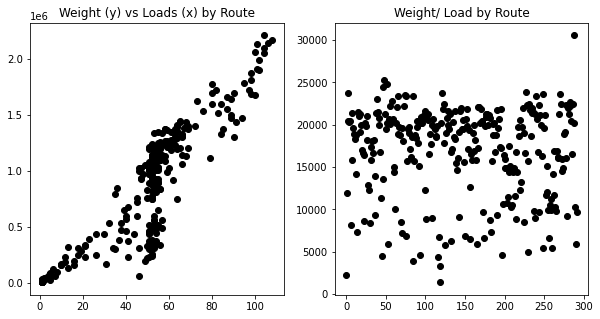

In [74]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].scatter(loads_by_route[['Total_Loads']],loads_by_route[['Total_Weight']], color='black')
axs[0].set_title('Weight (y) vs Loads (x) by Route')
axs[1].scatter(loads_by_route.index,loads_by_route[['Weight_By_Load']], color='black')
axs[1].set_title('Weight/ Load by Route')

* The weight per load relationship, in general terms, follows a linear distribution with little dispersion
* Although, there seems to be 3 different clusters when it comes the actual weight per load ratio: one around 20000,another aroung 15000 and a third between 5000 and 10000
* There's also a route that stands out completely that has the best relationship between weight and loads (around 30000)

In [326]:
print(loads_by_route['Weight_By_Load'].max(),loads_by_route['Weight_By_Load'].min())

30540.0 1387.1739130434783


In [88]:
# identifying the outlier
best_ratio = loads_by_route[(loads_by_route['Weight_By_Load'] == loads_by_route['Weight_By_Load'].max())].iloc[0]['Weight_By_Load']
best_route = loads_by_route[(loads_by_route['Weight_By_Load'] == loads_by_route['Weight_By_Load'].max())].iloc[0]['Route Number']
loads_by_route[(loads_by_route['Weight_By_Load'] == loads_by_route['Weight_By_Load'].max())]

,Route Number,Total_Weight,Total_Loads,Weight_By_Load
288,WNONAC,30540.0,1,30540.0


In [89]:
filtered_loads_df[(filtered_loads_df['Route Number'] == best_route)]

,Load Type,Load Time,Load Weight,Dropoff Site,Route Type,Route Number,Load ID,Load Date,Date,Time,Year,Month,Day
557019,GARBAGE COLLECTIONS,2019-04-10 17:28:00,30540.0,TDS LANDFILL,GARBAGE COLLECTION,WNONAC,822202,2019-04-10 00:00:00,2019-04-10,17:28:00,2019,04,10


<AxesSubplot:xlabel='Route Number', ylabel='Total_Loads'>

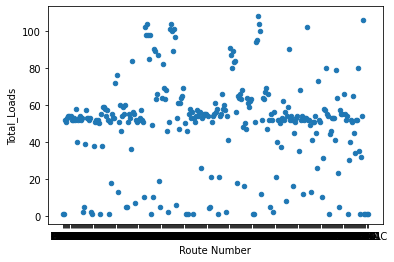

In [79]:
# dispersion of number of loads per route
loads_by_route.plot(x='Route Number', y ='Total_Loads', kind = 'scatter')

* The number of loads per route varies a lot, indicating that routes might change frequently
* Route number WNONAC indicates that it is possible to have a weight by load ratio of 30540
* Still, we'll focus on clustering the routes by ratio and analyse that distribution further

In [171]:
df_tofit = loads_by_route.copy()
df_tofit = df_tofit[['Weight_By_Load']]

# Using a basic KMeans algorithm 
kmeans = KMeans(n_clusters=3, max_iter=500)
kmeans.fit(df_tofit)

# Let's take a look at the results
clustered_routes = df_tofit.copy()
clustered_routes.insert(0, 'CLUSTER_LABEL', kmeans.labels_)
clustered_routes[['Route Number','Total_Loads', 'Total_Weight']] = loads_by_route[['Route Number','Total_Loads', 'Total_Weight']]

# Cluster stats table 
clustered_routes_grouped = clustered_routes.copy()
clustered_routes_grouped = clustered_routes_grouped.groupby('CLUSTER_LABEL').agg({'Route Number':'count', 'Weight_By_Load': 'mean'}).reset_index()
clustered_routes_grouped.rename(columns={"Route Number": "N_Routes"}, inplace=True)

#Sort by weight by load avg and change label names
clustered_routes_grouped.sort_values(by='Weight_By_Load', ascending=True, inplace=True)
clustered_routes_grouped.reset_index(inplace=True)
clustered_routes_grouped.drop('index', axis=1, inplace=True)

clustered_routes.loc[clustered_routes["CLUSTER_LABEL"] == clustered_routes_grouped.at[0,'CLUSTER_LABEL'], "CLUSTER_LABEL"] = '3. Low'
clustered_routes.loc[clustered_routes["CLUSTER_LABEL"] == clustered_routes_grouped.at[1,'CLUSTER_LABEL'], "CLUSTER_LABEL"] = '2. Medium'
clustered_routes.loc[clustered_routes["CLUSTER_LABEL"] == clustered_routes_grouped.at[2,'CLUSTER_LABEL'], "CLUSTER_LABEL"] = '1. High'

clustered_routes_grouped['CLUSTER_LABEL'] = clustered_routes_grouped['CLUSTER_LABEL'].astype(str)
clustered_routes_grouped.at[0,'CLUSTER_LABEL'] = '3. Low'
clustered_routes_grouped.at[1,'CLUSTER_LABEL'] = '2. Medium'
clustered_routes_grouped.at[2,'CLUSTER_LABEL'] = '1. High'
clustered_routes_grouped.head()



,CLUSTER_LABEL,N_Routes,Weight_By_Load
0,3. Low,62,8161.977039
1,2. Medium,78,15924.954798
2,1. High,152,20871.988608


In [172]:
clustered_routes

,CLUSTER_LABEL,Weight_By_Load,Route Number,Total_Loads,Total_Weight
0,3. Low,2280.000000,DW1,1,2280.0
1,3. Low,11940.000000,OH-4,1,11940.0
2,1. High,20425.000000,PAF01,52,1062100.0
3,1. High,23690.980392,PAF02,51,1208240.0
4,1. High,20360.000000,PAF03,53,1079080.0
...,...,...,...,...,...
287,1. High,20207.547170,PW41,106,2142000.0
288,1. High,30540.000000,WNONAC,1,30540.0
289,3. Low,10340.000000,YH06,1,10340.0
290,3. Low,5880.000000,YM11,1,5880.0


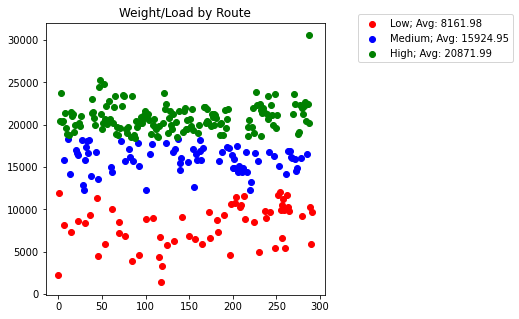

In [173]:
# Cluster chart
aux = clustered_routes.copy()
aux = aux.reset_index()
fig, axs = plt.subplots(1, figsize=(5,5), sharex=True)
axs.scatter(aux[aux['CLUSTER_LABEL']=='3. Low']['index'],aux[aux['CLUSTER_LABEL']=='3. Low']['Weight_By_Load'], color='red', label = f"Low; Avg: {round(clustered_routes_grouped.at[0,'Weight_By_Load'],2)}")
axs.scatter(aux[aux['CLUSTER_LABEL']=='2. Medium']['index'],aux[aux['CLUSTER_LABEL']=='2. Medium']['Weight_By_Load'], color='blue', label = f"Medium; Avg: {round(clustered_routes_grouped.at[1,'Weight_By_Load'],2)}")
axs.scatter(aux[aux['CLUSTER_LABEL']=='1. High']['index'],aux[aux['CLUSTER_LABEL']=='1. High']['Weight_By_Load'], color='green', label = f"High; Avg: {round(clustered_routes_grouped.at[2,'Weight_By_Load'],2)}")
axs.set_title('Weight/Load by Route')
axs.legend(bbox_to_anchor=(1.1, 1.05))



#### Route Clusters Visualitzation

In [174]:
garbage_boundaries = gpd.read_file('garbage_routes.geojson')
garbage_boundaries = garbage_boundaries.drop_duplicates(subset = ['garb_rt', 'rt_old'])
route_numbers = list(garbage_boundaries['garb_rt'])
route_numbers =route_numbers + list(garbage_boundaries['rt_old'])
route_numbers = list(set(route_numbers))
route_numbers.remove('NO ROUTE')
route_numbers.remove(None)
garbage_boundaries.head()

,rt_old,garb_day,landfill,garb_rt,super_num,op_type,garb_sup,geometry
0,None,Thursday,TDS,PAH83,697,Auto,Gilbert,"MULTIPOLYGON (((-97.70618 30.36742, -97.70723 ..."
1,PAM84,Monday,TDS,PAM54,500,Auto,Castillo,"MULTIPOLYGON (((-97.83237 30.16213, -97.83237 ..."
2,None,Monday,TDS,PAM71,596,Auto,Carnline,"MULTIPOLYGON (((-97.72977 30.19009, -97.72103 ..."
3,PAH75,Thursday,TDS,PAH54,500,Auto,Castillo,"MULTIPOLYGON (((-97.65374 30.26269, -97.65322 ..."
4,None,Wednesday,TDS,PAW71,596,Auto,Carnline,"MULTIPOLYGON (((-97.64683 30.38640, -97.64724 ..."


In [175]:
clustered_routes['geometry'] = np.nan
loads_by_route_geo = clustered_routes.set_index("Route Number")
loads_by_route_geo = gpd.GeoDataFrame(loads_by_route_geo)
for garb_rt in route_numbers:
    try:
        if not garbage_boundaries.loc[garbage_boundaries['garb_rt'] == garb_rt]['geometry'].empty:
            loads_by_route_geo.at[garb_rt, 'geometry'] = garbage_boundaries.loc[garbage_boundaries['garb_rt'] == garb_rt]['geometry'].iloc[0]
        elif not garbage_boundaries.loc[garbage_boundaries['rt_old'] == garb_rt]['geometry'].empty:
            loads_by_route_geo.at[garb_rt, 'geometry'] = garbage_boundaries.loc[garbage_boundaries['rt_old'] == garb_rt]['geometry'].iloc[0]
    except:
        pass
    
            
loads_by_route_geo = loads_by_route_geo.reset_index()
loads_by_route_geo.dropna(inplace=True)
loads_by_route_geo.head()

,Route Number,CLUSTER_LABEL,Weight_By_Load,Total_Loads,Total_Weight,geometry
2,PAF01,1. High,20425.000000,52.0,1062100.0,"MULTIPOLYGON (((-97.80021 30.36734, -97.79845 ..."
3,PAF02,1. High,23690.980392,51.0,1208240.0,"MULTIPOLYGON (((-97.77222 30.32272, -97.77117 ..."
4,PAF03,1. High,20360.000000,53.0,1079080.0,"MULTIPOLYGON (((-97.76012 30.34036, -97.75954 ..."
5,PAF04,1. High,20431.111111,54.0,1103280.0,"MULTIPOLYGON (((-97.77663 30.30588, -97.77664 ..."
8,PAF50,1. High,21351.923077,52.0,1110300.0,"MULTIPOLYGON (((-97.77245 30.29746, -97.77172 ..."


In [238]:
# Cluster stats table 
clustered_routes_grouped = loads_by_route_geo.copy()
clustered_routes_grouped = clustered_routes_grouped.groupby('CLUSTER_LABEL').agg({'Route Number':'count', 'Weight_By_Load': 'mean'}).reset_index()
clustered_routes_grouped.rename(columns={"Route Number": "N_Routes"}, inplace=True)

#Sort by weight by load avg and change label names
clustered_routes_grouped.sort_values(by='Weight_By_Load', ascending=True, inplace=True)
clustered_routes_grouped.reset_index(inplace=True)
clustered_routes_grouped.drop('index', axis=1, inplace=True)

clustered_routes.loc[clustered_routes["CLUSTER_LABEL"] == clustered_routes_grouped.at[0,'CLUSTER_LABEL'], "CLUSTER_LABEL"] = '3. Low'
clustered_routes.loc[clustered_routes["CLUSTER_LABEL"] == clustered_routes_grouped.at[1,'CLUSTER_LABEL'], "CLUSTER_LABEL"] = '2. Medium'
clustered_routes.loc[clustered_routes["CLUSTER_LABEL"] == clustered_routes_grouped.at[2,'CLUSTER_LABEL'], "CLUSTER_LABEL"] = '1. High'

clustered_routes_grouped['CLUSTER_LABEL'] = clustered_routes_grouped['CLUSTER_LABEL'].astype(str)
clustered_routes_grouped.at[0,'CLUSTER_LABEL'] = '3. Low'
clustered_routes_grouped.at[1,'CLUSTER_LABEL'] = '2. Medium'
clustered_routes_grouped.at[2,'CLUSTER_LABEL'] = '1. High'
clustered_routes_grouped.head()

,CLUSTER_LABEL,N_Routes,Weight_By_Load
0,3. Low,7,11263.442085
1,2. Medium,52,16340.461801
2,1. High,145,20810.587155


Routes with Lowest ratios:

In [312]:
loads_by_route_geo.loc[clustered_routes["CLUSTER_LABEL"] == "3. Low"]

,Route Number,CLUSTER_LABEL,Weight_By_Load,Total_Loads,Total_Weight,geometry,Area,Miles,Load_Emissions
44,PAH07,3. Low,11360.000000,1.0,11360.0,"MULTIPOLYGON (((-97.75719 30.37167, -97.75723 ...",1.071746,2.727420,20.419281
208,PF23,3. Low,10254.594595,37.0,379420.0,"MULTIPOLYGON (((-97.69183 30.26334, -97.69535 ...",1.080043,2.748534,20.577360
252,PT10,3. Low,11752.000000,55.0,646360.0,"MULTIPOLYGON (((-97.75145 30.21643, -97.75360 ...",1.386481,3.528368,26.415718
254,PT12,3. Low,12020.000000,1.0,12020.0,"MULTIPOLYGON (((-97.75431 30.19338, -97.75516 ...",0.633209,1.611414,12.064119
257,PT20,3. Low,10505.660377,53.0,556800.0,"MULTIPOLYGON (((-97.73573 30.24990, -97.73543 ...",0.833551,2.121251,15.881100
258,PT21,3. Low,11234.339623,53.0,595420.0,"MULTIPOLYGON (((-97.73504 30.24465, -97.73523 ...",1.282423,3.263557,24.433162
262,PT31,3. Low,11717.500000,64.0,749920.0,"MULTIPOLYGON (((-97.70488 30.25109, -97.70338 ...",4.613990,11.741852,87.907334


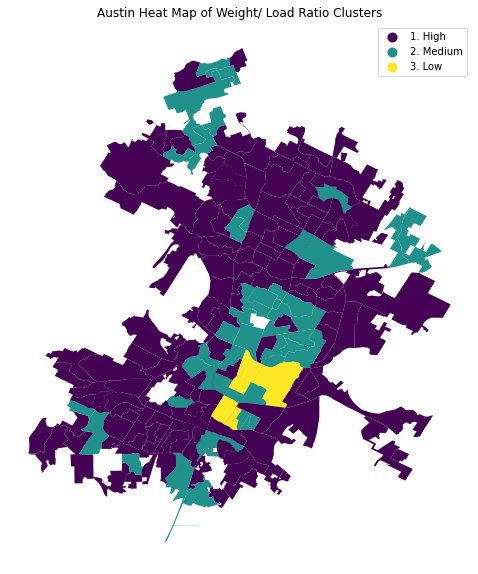

In [315]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.set_axis_off()
loads_by_route_geo.plot(column = 'CLUSTER_LABEL', cmap='viridis', legend=True, categorical=True, ax=ax)
ax.set_title("Austin Heat Map of Weight/ Load Ratio Clusters")
plt.show()

#### Estimating the impact of reducing the number of loads for the "Medium" and "Low" ratio routes

A typical Side Loader Garbage Trucks (common for the removal of household waste) can take up to around 30000lbs of garbage (1). As the best route weight per load was 30540lbs, than we'll assume that each load correponds to a truck trip.

Research shows that loaded dump trucks had approximately 30% higher fuel consumption than when empty (2). We can, then estimate the increase in fuel cosumption by an additional pound of waste collected as 30%/30000 = 0.001%

Diesel combustion can generate 22.46 pounds of CO2 per gallon consumed (3) and diesel fueled garbage tracks average 3 miles per gallon (4), i.e. these trucks can emit 22.46 * 1/3 =  7.48 pounds of CO2 per mile, with an increase of (((1+0.001/100)*1/3) * 22.46) - 7.48)/ 7.48 = 0.00099%

Austin has an area of 319.9 sq mi (5), while Texas as an area of 268596 square miles (6) with 683533 miles of roads (7). Allowing us to estimate that Austin would have arount 319.9/268596 * 683533 = 814 miles of roads.

Sources:
* (1) https://routereadytrucks.com/blogs/know-4-major-types-garbage-trucks/according
* (2) https://www.tandfonline.com/doi/full/10.1080/10962247.2014.990587
* (3) https://www.eia.gov/environment/emissions/co2_vol_mass.php
* (4) https://qz.com/749622/the-economics-of-electric-garbage-trucks-arewesome/#:~:text=Garbage%20trucks%20are%20one%20of,of%20the%20average%20US%20home.
* (5) https://worldpopulationreview.com/us-cities/austin-tx-population
* (6) https://worldpopulationreview.com/state-rankings/states-by-area
* (7) https://blog.cubitplanning.com/2010/02/road-miles-by-state/

In [208]:
co2_emission_per_mile = 22.46/3
road_miles_per_sqrmile = 683533/268596
austin_roadmiles = 319.9 * road_miles_per_sqrmile
co2_increase_per_waste_lbs_perct = (22.46*((1+(30/100)/30000)/3) - co2_emission_per_mile)/co2_emission_per_mile *100
print(co2_emission_per_mile, road_miles_per_sqrmile, austin_roadmiles, co2_increase_per_waste_lbs_perct)

7.486666666666667 2.5448368553515315 814.0933100269549 0.0009999999999926708


In [191]:
# calculating area of each route to estimate CO2 emissions per load
loads_by_route_geo['Area']=loads_by_route_geo['geometry'].area
polygon_area = loads_by_route_geo['Area'].sum()
# change area to sqr miles
polygon_vs_real_ratio = 319.9 / polygon_area
loads_by_route_geo['Area'] = loads_by_route_geo['Area'] * polygon_vs_real_ratio
# calculate road miles
loads_by_route_geo['Miles'] = loads_by_route_geo['Area'] * road_miles_per_sqrmile 
# calculate emission per load
loads_by_route_geo['Load_Emissions'] = loads_by_route_geo['Miles'] * co2_emission_per_mile 

loads_by_route_geo.head()

,Route Number,CLUSTER_LABEL,Weight_By_Load,Total_Loads,Total_Weight,geometry,Area,Miles,Load_Emissions
2,PAF01,1. High,20425.000000,52.0,1062100.0,"MULTIPOLYGON (((-97.80021 30.36734, -97.79845 ...",4.672814,11.891549,89.028066
3,PAF02,1. High,23690.980392,51.0,1208240.0,"MULTIPOLYGON (((-97.77222 30.32272, -97.77117 ...",1.840340,4.683365,35.062793
4,PAF03,1. High,20360.000000,53.0,1079080.0,"MULTIPOLYGON (((-97.76012 30.34036, -97.75954 ...",2.123601,5.404217,40.459574
5,PAF04,1. High,20431.111111,54.0,1103280.0,"MULTIPOLYGON (((-97.77663 30.30588, -97.77664 ...",1.362570,3.467520,25.960163
8,PAF50,1. High,21351.923077,52.0,1110300.0,"MULTIPOLYGON (((-97.77245 30.29746, -97.77172 ...",0.852264,2.168873,16.237628


In [267]:
# Total CO2 emissions in 2019
real_emissions = loads_by_route_geo['Load_Emissions'] + (co2_increase_per_waste_lbs_perct / 100 * loads_by_route_geo['Weight_By_Load'])
em = round(sum(real_emissions*loads_by_route_geo['Total_Loads']))
print(f"Total CO2 emissions 2019: {em} lbs")



Total CO2 emissions 2019: 390599 lbs


Considering that there might be many reasons for it to be necessary to complete a route even if there is not that much waste to collect, such as:
* poor or low capacity trash cans
* impossibility for the garbage to be on the streets for more than a specific amount of time
* ...

Then, it's reasonable to be conservative in the estimations of potential reduction in the number of loads. Therefore, we'll do it by shifting up the weight by load of each route by the difference between each clusters average and the average of the 'high' cluster (except when the route only has 1 load).

In [273]:
# Loads per route if Low and Medium routes shifted up by the average
low_shift = clustered_routes_grouped.at[2,'Weight_By_Load'] - clustered_routes_grouped.at[0,'Weight_By_Load']
medium_shift = clustered_routes_grouped.at[2,'Weight_By_Load'] - clustered_routes_grouped.at[1,'Weight_By_Load']

optimized_routes_df = loads_by_route_geo.copy()
optimized_routes_df.loc[(optimized_routes_df['CLUSTER_LABEL'] == '3. Low') & (optimized_routes_df['Total_Loads'] != 1),'Weight_By_Load'] = optimized_routes_df.loc[optimized_routes_df['CLUSTER_LABEL'] == '3. Low','Weight_By_Load'] + low_shift
optimized_routes_df.loc[(optimized_routes_df['CLUSTER_LABEL'] == '2. Medium') & (optimized_routes_df['Total_Loads'] != 1),'Weight_By_Load'] = optimized_routes_df.loc[optimized_routes_df['CLUSTER_LABEL'] == '2. Medium','Weight_By_Load'] + medium_shift

optimized_routes_df['Total_Loads'] = optimized_routes_df['Total_Weight'] / optimized_routes_df['Weight_By_Load']
print(f"Current Loads: {loads_by_route_geo['Total_Loads'].sum()}")
print(f"Optimized Loads: {optimized_routes_df['Total_Loads'].sum()}")



Current Loads: 11848.0
Optimized Loads: 11119.204446461543


In [274]:
# Total CO2 emissions reduced
real_emissions = optimized_routes_df['Load_Emissions'] + (co2_increase_per_waste_lbs_perct / 100 * optimized_routes_df['Weight_By_Load'])
em_opt = round(sum(real_emissions*optimized_routes_df['Total_Loads']))
print(f"Emissions Optimized: {em_opt} lbs")
print(f"Reduction: {round((em - em_opt)/em * 100, 2)}%")


Emissions Optimized: 369221 lbs
Reduction: 5.47%


Text(0.5, 1.0, 'Weight/ Load by Route Real')

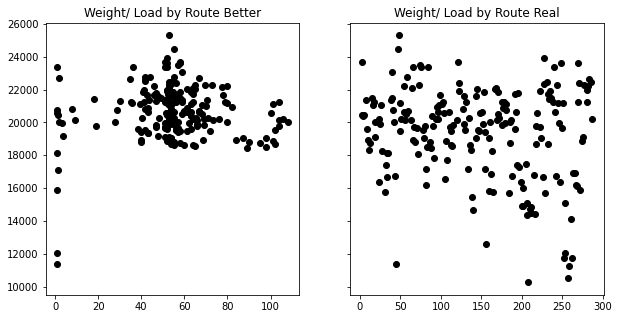

In [280]:
fig, axs = plt.subplots(1,2, figsize=(10,5), sharey = True)
axs[0].scatter(optimized_routes_df[['Total_Loads']],optimized_routes_df[['Weight_By_Load']], color='black')
axs[0].set_title('Weight/ Load by Route Better')
axs[1].scatter(loads_by_route_geo.index,loads_by_route_geo[['Weight_By_Load']], color='black')
axs[1].set_title('Weight/ Load by Route Real')

#### Non-Linear Programming: Finding optimal number of loads per route

In [293]:
# model inputs
max_load_capacity = 30000
routes_df = loads_by_route_geo.copy()
co2_increase_per_waste_lbs_perct = co2_increase_per_waste_lbs_perct

for index, row in routes_df.iterrows():
    
    #initialize model
    m = GEKKO(remote=True)

    #decision variables
    weight_by_load = m.Var(value=routes_df.at[index,"Weight_By_Load"], lb=0, ub=max_load_capacity)

    #Objective minimize CO2
    m.Minimize((weight_by_load * co2_increase_per_waste_lbs_perct / 100 + routes_df.at[index,"Load_Emissions"])*(routes_df.at[index,"Total_Weight"])/weight_by_load)

    #set options
    m.options.IMODE = 3 #steady state optimization
    
    #solve
    m.solve()
    
    # change values on route df
    routes_df.at[index,"Weight_By_Load"] = weight_by_load.value[0]


routes_df


#########################
#########2#########
#########################
apm 193.136.33.115_gk_model8 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

**********************

apm 193.136.33.115_gk_model10 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program c

Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 4
Total CPU secs in IPOPT (w/o function evaluations)   =      0.003
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
 
 The solution was found.
 
 The final value of the objective function is    612.057589106184     
 
 ---------------------------------------------------
 Solver         :  IPOPT (v3.12)
 Solution time  :   1.080000000365544E-002 sec
 Objective      :    612.057594147080     
 Successful solution
 ---------------------------------------------------
 
#########################
#########9#########
#########################
apm 193.136.33.115_gk_model13 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1

#########################
#########11#########
#########################
apm 193.136.33.115_gk_model15 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

********************

#########################
#########15#########
#########################
apm 193.136.33.115_gk_model17 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

********************

apm 193.136.33.115_gk_model19 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program c

apm 193.136.33.115_gk_model21 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program c

apm 193.136.33.115_gk_model23 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program c

#########################
#########27#########
#########################
apm 193.136.33.115_gk_model26 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

********************

#########################
#########32#########
#########################
apm 193.136.33.115_gk_model28 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

********************

#########################
#########34#########
#########################
apm 193.136.33.115_gk_model30 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

********************

#########################
#########38#########
#########################
apm 193.136.33.115_gk_model32 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

********************

apm 193.136.33.115_gk_model34 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program c

#########################
#########43#########
#########################
apm 193.136.33.115_gk_model37 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

********************

#########################
#########47#########
#########################
apm 193.136.33.115_gk_model39 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

********************

apm 193.136.33.115_gk_model41 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program c

apm 193.136.33.115_gk_model43 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program c

#########################
#########56#########
#########################
apm 193.136.33.115_gk_model46 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

********************

apm 193.136.33.115_gk_model48 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program c

 Solution time  :   8.099999991827644E-003 sec
 Objective      :    555.407916897056     
 Successful solution
 ---------------------------------------------------
 
#########################
#########64#########
#########################
apm 193.136.33.115_gk_model51 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 *******************************

#########################
#########66#########
#########################
apm 193.136.33.115_gk_model53 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

********************

#########################
#########68#########
#########################
apm 193.136.33.115_gk_model55 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

********************

#########################
#########72#########
#########################
apm 193.136.33.115_gk_model57 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

********************

#########################
#########74#########
#########################
apm 193.136.33.115_gk_model59 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

********************

apm 193.136.33.115_gk_model61 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program c

#########################
#########80#########
#########################
apm 193.136.33.115_gk_model63 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

********************

#########################
#########82#########
#########################
apm 193.136.33.115_gk_model65 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

********************

#########################
#########84#########
#########################
apm 193.136.33.115_gk_model67 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

********************

#########################
#########88#########
#########################
apm 193.136.33.115_gk_model69 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

********************

#########################
#########90#########
#########################
apm 193.136.33.115_gk_model71 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

********************

#########################
#########94#########
#########################
apm 193.136.33.115_gk_model73 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

********************

apm 193.136.33.115_gk_model75 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program c

#########################
#########99#########
#########################
apm 193.136.33.115_gk_model78 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

********************

apm 193.136.33.115_gk_model80 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program c

 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.10, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        1

Total number of variables............................:        1
                     variab

   5  3.0532977e+03 0.00e+00 2.49e-10 -11.0 2.00e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   5.9388550046168461e+01    3.0532977440713362e+03
Dual infeasibility......:   2.4893154204619350e-10    1.2798125483228195e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.1829131309552518e-10    6.0816200957427669e-09
Overall NLP error.......:   2.4893154204619350e-10    1.2798125483228195e-08


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o fun

Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o function evaluations)   =      0.003
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
 
 The solution was found.
 
 The final value of the objective function is    411.370053463324     
 
 ---------------------------------------------------
 Solver         :  IPOPT (v3.12)
 Solution time  :   1.269999999203719E-002 sec
 Objective      :    411.370057484261     
 Successful solution
 ---------------------------------------------------
 
#########################
#########112#########
#########################
apm 193.136.33.115_gk_model87 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :         

#########################
#########114#########
#########################
apm 193.136.33.115_gk_model89 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

*******************

#########################
#########120#########
#########################
apm 193.136.33.115_gk_model91 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

*******************

apm 193.136.33.115_gk_model93 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program c

 Objective      :    587.772257463835     
 Successful solution
 ---------------------------------------------------
 
#########################
#########128#########
#########################
apm 193.136.33.115_gk_model96 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization wit

#########################
#########130#########
#########################
apm 193.136.33.115_gk_model98 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

*******************

#########################
#########134#########
#########################
apm 193.136.33.115_gk_model100 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

#########################
#########136#########
#########################
apm 193.136.33.115_gk_model102 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

 Successful solution
 ---------------------------------------------------
 
#########################
#########139#########
#########################
apm 193.136.33.115_gk_model104 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 *****************

#########################
#########143#########
#########################
apm 193.136.33.115_gk_model106 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

#########################
#########145#########
#########################
apm 193.136.33.115_gk_model108 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

#########################
#########147#########
#########################
apm 193.136.33.115_gk_model110 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

#########################
#########151#########
#########################
apm 193.136.33.115_gk_model112 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

apm 193.136.33.115_gk_model114 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program 

#########################
#########155#########
#########################
apm 193.136.33.115_gk_model116 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

#########################
#########159#########
#########################
apm 193.136.33.115_gk_model118 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

#########################
#########161#########
#########################
apm 193.136.33.115_gk_model120 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

#########################
#########163#########
#########################
apm 193.136.33.115_gk_model122 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

#########################
#########167#########
#########################
apm 193.136.33.115_gk_model124 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

apm 193.136.33.115_gk_model126 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program 

 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.10, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        1

Total number of variables............................:        1
                     variab

#########################
#########176#########
#########################
apm 193.136.33.115_gk_model131 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

apm 193.136.33.115_gk_model133 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program 

#########################
#########181#########
#########################
apm 193.136.33.115_gk_model136 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

#########################
#########185#########
#########################
apm 193.136.33.115_gk_model138 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

#########################
#########187#########
#########################
apm 193.136.33.115_gk_model140 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

#########################
#########191#########
#########################
apm 193.136.33.115_gk_model142 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

#########################
#########193#########
#########################
apm 193.136.33.115_gk_model144 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

#########################
#########195#########
#########################
apm 193.136.33.115_gk_model146 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

#########################
#########199#########
#########################
apm 193.136.33.115_gk_model148 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

#########################
#########201#########
#########################
apm 193.136.33.115_gk_model150 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

#########################
#########205#########
#########################
apm 193.136.33.115_gk_model152 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

#########################
#########207#########
#########################
apm 193.136.33.115_gk_model154 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

#########################
#########210#########
#########################
apm 193.136.33.115_gk_model156 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

#########################
#########212#########
#########################
apm 193.136.33.115_gk_model158 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

#########################
#########216#########
#########################
apm 193.136.33.115_gk_model160 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

#########################
#########218#########
#########################
apm 193.136.33.115_gk_model162 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

#########################
#########222#########
#########################
apm 193.136.33.115_gk_model164 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

 
#########################
#########224#########
#########################
apm 193.136.33.115_gk_model166 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

****************

#########################
#########227#########
#########################
apm 193.136.33.115_gk_model168 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

apm 193.136.33.115_gk_model170 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program 

#########################
#########232#########
#########################
apm 193.136.33.115_gk_model172 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

#########################
#########234#########
#########################
apm 193.136.33.115_gk_model174 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

apm 193.136.33.115_gk_model176 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program 

#########################
#########241#########
#########################
apm 193.136.33.115_gk_model179 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

#########################
#########244#########
#########################
apm 193.136.33.115_gk_model181 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

apm 193.136.33.115_gk_model183 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program 

#########################
#########249#########
#########################
apm 193.136.33.115_gk_model185 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

#########################
#########251#########
#########################
apm 193.136.33.115_gk_model187 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

#########################
#########253#########
#########################
apm 193.136.33.115_gk_model189 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

#########################
#########257#########
#########################
apm 193.136.33.115_gk_model191 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

#########################
#########261#########
#########################
apm 193.136.33.115_gk_model193 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

#########################
#########263#########
#########################
apm 193.136.33.115_gk_model195 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

#########################
#########267#########
#########################
apm 193.136.33.115_gk_model197 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

#########################
#########269#########
#########################
apm 193.136.33.115_gk_model199 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

apm 193.136.33.115_gk_model201 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program 

#########################
#########275#########
#########################
apm 193.136.33.115_gk_model203 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

#########################
#########277#########
#########################
apm 193.136.33.115_gk_model205 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

apm 193.136.33.115_gk_model207 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program 

#########################
#########286#########
#########################
apm 193.136.33.115_gk_model210 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            1
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:              1
 Number of total equations: -            0
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************

,Route Number,CLUSTER_LABEL,Weight_By_Load,Total_Loads,Total_Weight,geometry,Area,Miles,Load_Emissions
2,PAF01,1. High,30000.0,52.0,1062100.0,"MULTIPOLYGON (((-97.80021 30.36734, -97.79845 ...",4.672814,11.891549,89.028066
3,PAF02,1. High,30000.0,51.0,1208240.0,"MULTIPOLYGON (((-97.77222 30.32272, -97.77117 ...",1.840340,4.683365,35.062793
4,PAF03,1. High,30000.0,53.0,1079080.0,"MULTIPOLYGON (((-97.76012 30.34036, -97.75954 ...",2.123601,5.404217,40.459574
5,PAF04,1. High,30000.0,54.0,1103280.0,"MULTIPOLYGON (((-97.77663 30.30588, -97.77664 ...",1.362570,3.467520,25.960163
8,PAF50,1. High,30000.0,52.0,1110300.0,"MULTIPOLYGON (((-97.77245 30.29746, -97.77172 ...",0.852264,2.168873,16.237628
...,...,...,...,...,...,...,...,...,...
281,PW31,1. High,30000.0,52.0,1103220.0,"MULTIPOLYGON (((-97.67217 30.38963, -97.67251 ...",0.766351,1.950239,14.600788
282,PW32,1. High,30000.0,80.0,1777320.0,"MULTIPOLYGON (((-97.62770 30.35480, -97.63059 ...",4.728966,12.034448,90.097902
283,PW33,1. High,30000.0,35.0,793160.0,"MULTIPOLYGON (((-97.62770 30.35480, -97.63059 ...",4.728966,12.034448,90.097902
286,PW40,1. High,30000.0,54.0,1212220.0,"MULTIPOLYGON (((-97.67112 30.36307, -97.67204 ...",0.626519,1.594389,11.936655


In [306]:
routes_df['Total_Loads'] = routes_df['Total_Weight']/routes_df['Weight_By_Load']
routes_df['Total_Loads'] = routes_df['Total_Loads'].apply(lambda x: math.ceil(x))
routes_df

,Route Number,CLUSTER_LABEL,Weight_By_Load,Total_Loads,Total_Weight,geometry,Area,Miles,Load_Emissions
2,PAF01,1. High,30000.0,36,1062100.0,"MULTIPOLYGON (((-97.80021 30.36734, -97.79845 ...",4.672814,11.891549,89.028066
3,PAF02,1. High,30000.0,41,1208240.0,"MULTIPOLYGON (((-97.77222 30.32272, -97.77117 ...",1.840340,4.683365,35.062793
4,PAF03,1. High,30000.0,36,1079080.0,"MULTIPOLYGON (((-97.76012 30.34036, -97.75954 ...",2.123601,5.404217,40.459574
5,PAF04,1. High,30000.0,37,1103280.0,"MULTIPOLYGON (((-97.77663 30.30588, -97.77664 ...",1.362570,3.467520,25.960163
8,PAF50,1. High,30000.0,38,1110300.0,"MULTIPOLYGON (((-97.77245 30.29746, -97.77172 ...",0.852264,2.168873,16.237628
...,...,...,...,...,...,...,...,...,...
281,PW31,1. High,30000.0,37,1103220.0,"MULTIPOLYGON (((-97.67217 30.38963, -97.67251 ...",0.766351,1.950239,14.600788
282,PW32,1. High,30000.0,60,1777320.0,"MULTIPOLYGON (((-97.62770 30.35480, -97.63059 ...",4.728966,12.034448,90.097902
283,PW33,1. High,30000.0,27,793160.0,"MULTIPOLYGON (((-97.62770 30.35480, -97.63059 ...",4.728966,12.034448,90.097902
286,PW40,1. High,30000.0,41,1212220.0,"MULTIPOLYGON (((-97.67112 30.36307, -97.67204 ...",0.626519,1.594389,11.936655


In [307]:
real_emissions = routes_df['Load_Emissions'] + (co2_increase_per_waste_lbs_perct / 100 * routes_df['Weight_By_Load'])
em_opt = round(sum(real_emissions*routes_df['Total_Loads']))
print(f"Emissions Optimized: {em_opt} lbs")
print(f"Reduction: {round((em - em_opt)/em * 100, 2)}%")

Emissions Optimized: 258400 lbs
Reduction: 33.85%


In [318]:
temp = loads_by_route_geo.reset_index()[['Route Number', 'Total_Loads' ,'Weight_By_Load', 'Total_Weight']]
pd.set_option('display.max_rows', None)
temp

,Route Number,Total_Loads,Weight_By_Load,Total_Weight
0,PAF01,52.0,20425.000000,1062100.0
1,PAF02,51.0,23690.980392,1208240.0
2,PAF03,53.0,20360.000000,1079080.0
3,PAF04,54.0,20431.111111,1103280.0
4,PAF50,52.0,21351.923077,1110300.0
5,PAF51,52.0,19573.076923,1017800.0
6,PAF52,53.0,18955.471698,1004640.0
7,PAF53,52.0,18300.000000,951600.0
8,PAF54,58.0,18750.344828,1087520.0
9,PAF60,53.0,21483.773585,1138640.0
